# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from scipy.signal import periodogram

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

(2000, 100)


Text(0.5, 1.0, 'Autocorrelation pour N = 2000')

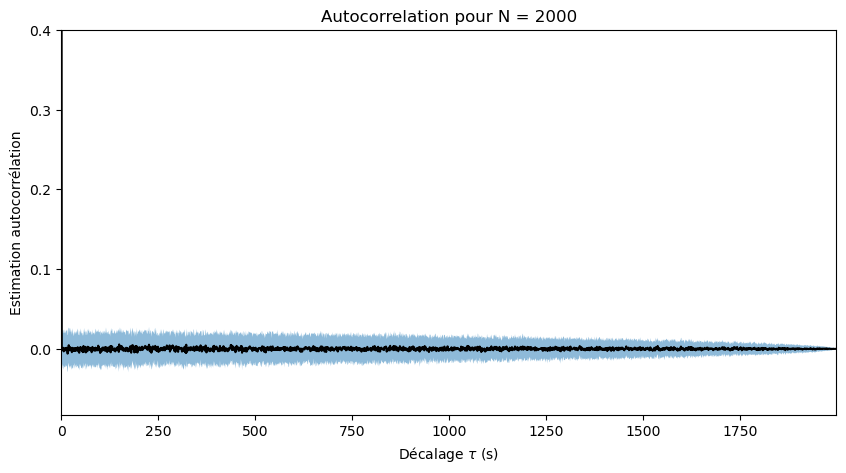

In [63]:
def gamma(X,tau):
    N = X.shape[0]
    if tau < 0:
        tau = -tau
    return (1/N)* np.sum(X[:N - tau]* X[tau:] , axis =0)

N = 2000

fig, ax = fig_ax(figsize=(10, 5))
X = np.random.normal(0, 1, (N,100))
gammas = np.array([gamma(X,tau) for tau in range(N)])
print(gammas.shape)
avg = gammas.mean(axis=1)
std = gammas.std(axis=1)
ax.plot(range(N),avg,'k-')
ax.fill_between(range(N),avg-std,avg+std,alpha=0.5)
ax.set_ylim(top=0.4)
ax.set_ylabel("Estimation autocorrélation")
ax.set_xlabel(r'Décalage $\tau$ (s)')
ax.set_title(f"Autocorrelation pour N = {N}")

Text(0.5, 1.0, 'Périodogramme pour N = 200')

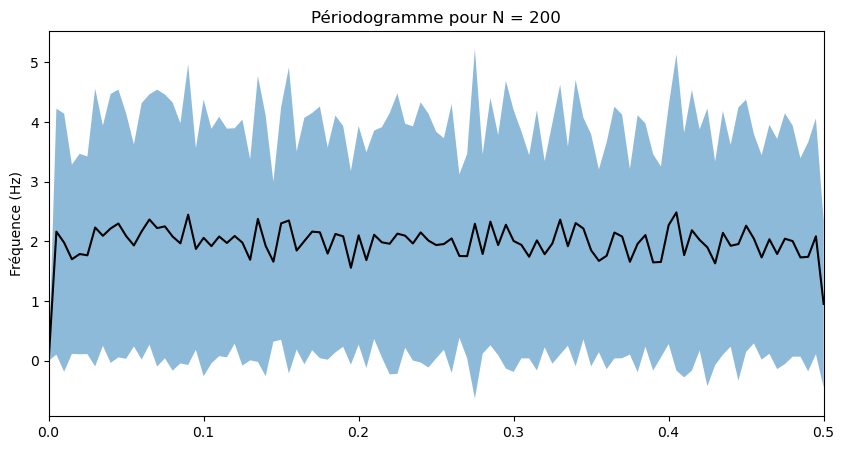

In [54]:
# Nombre de samples et taille de chaque sample
num_samples = 100
N = 200
variance = 1

# Générer 100 samples de bruit blanc gaussien avec une variance de 1
Y = np.random.normal(loc=0, scale=np.sqrt(variance), size=(num_samples, N))
freqs = np.linspace(0, 0.5 ,100)
# Calculer le periodogramme pour chaque sample
periodograms = np.array([periodogram(sample, fs=1)[1] for sample in Y])
freqs = periodogram(Y[0], fs=1)[0]
fig, ax = fig_ax(figsize=(10, 5))
avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs,avg,'k-')
ax.fill_between(freqs,avg-std,avg+std,alpha=0.5)
ax.set_ylabel("Estimation de densité spectrale")
ax.set_ylabel("Fréquence (Hz)")
ax.set_title(f"Périodogramme pour N = {N}")

## Question 9

In [ ]:
from scipy.signal import welch

N = 500
# Nous allons suivre une procédure similaire à celle du periodogramme pour la méthode de Barlett
# Générer 100 samples de bruit blanc gaussien avec une variance de 1
Y = np.random.normal(loc=0, scale=np.sqrt(variance), size=(num_samples, N))

# Calculer le periodogramme pour chaque sample en utilisant la méthode de Welch (équivalent à Barlett)
# avec un segment de la même longueur que le signal pour reproduire les conditions de l'exemple précédent
barletts = np.array([welch(sample, fs=1, nperseg=N//5)[1] for sample in Y])
freqs_welch = welch(Y[0], fs=1, nperseg=N//5)[0]

# Calcul de la moyenne et de l'écart-type pour les estimations obtenues par la méthode de Barlett
avg_welch = barletts.mean(axis=0)
std_welch = barletts.std(axis=0)

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freqs_welch, avg_welch, 'k-')
ax.fill_between(freqs_welch, avg_welch - std_welch, avg_welch + std_welch, alpha=0.5)
ax.set_ylabel("Estimation de densité spectrale")
ax.set_xlabel("Fréquence (Hz)")
ax.set_title(f"Estimation de la densité spectrale de puissance par la méthode de Barlett pour N = {N}")

# Afficher le graphique
plt.show()


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [4]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [40]:
from IPython.display import Audio, display
from dtw import dtw

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold,GridSearchCV,KFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter 

In [6]:
FREQUENCY = 100

In [7]:
X_train

[array([ 0.05121023,  0.09063256,  0.1302168 ,  0.1403377 ,  0.248104  ,
         0.2734045 ,  0.2363019 ,  0.2712793 ,  0.3662439 ,  0.5072172 ,
         0.4167981 ,  0.203238  ,  0.09763679,  0.1495837 ,  0.2107776 ,
         0.2272293 ,  0.2059888 ,  0.1900259 ,  0.19517   ,  0.2035186 ,
         0.2050538 ,  0.2087925 ,  0.2281164 ,  0.2674241 ,  0.2910711 ,
         0.3234624 ,  0.3532823 ,  0.3727821 ,  0.3788307 ,  0.3871034 ,
         0.3884732 ,  0.3989419 ,  0.4097715 ,  0.4259535 ,  0.4310263 ,
         0.4276275 ,  0.4069343 ,  0.3977635 ,  0.3979597 ,  0.4003914 ,
         0.360804  ,  0.3220959 ,  0.284952  ,  0.268509  ,  0.2611522 ,
         0.2362874 ,  0.1791516 ,  0.1101788 ,  0.06730135,  0.08448989,
         0.09056924,  0.05798818, -0.00429547, -0.06019713, -0.09728605,
        -0.1697698 , -0.2247379 , -0.2618523 , -0.305473  , -0.3602859 ,
        -0.4248538 , -0.5033626 , -0.5663265 , -0.6472536 , -0.7348635 ,
        -0.8231965 , -0.820279  , -0.7294056 , -0.6

#### DATA VIZUALISATION

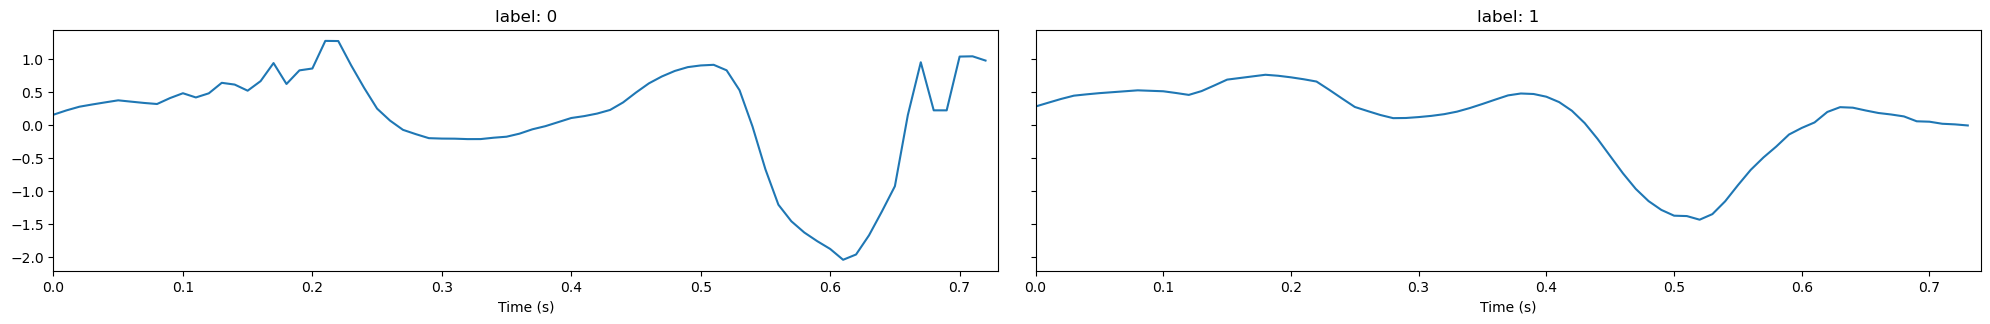

In [8]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([2, 22], ax_arr):
    s = X_train[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    _ = ax.set_title(f"label: {y_train[ind]}")

In [9]:
for ind in [2, 22]:
    signal = X_train[ind]
    label = y_train[ind]
    print(label)
    display(Audio(signal, rate=FREQUENCY))

0


1


In [10]:
signal_1, label_1 = X_train[2], y_train[2]
signal_2, label_2 = X_train[22], y_train[22]

In [11]:
def get_dtw_distance(signal_1, signal_2):
    return (dtw(signal_1, signal_2, keep_internals=True).distance)

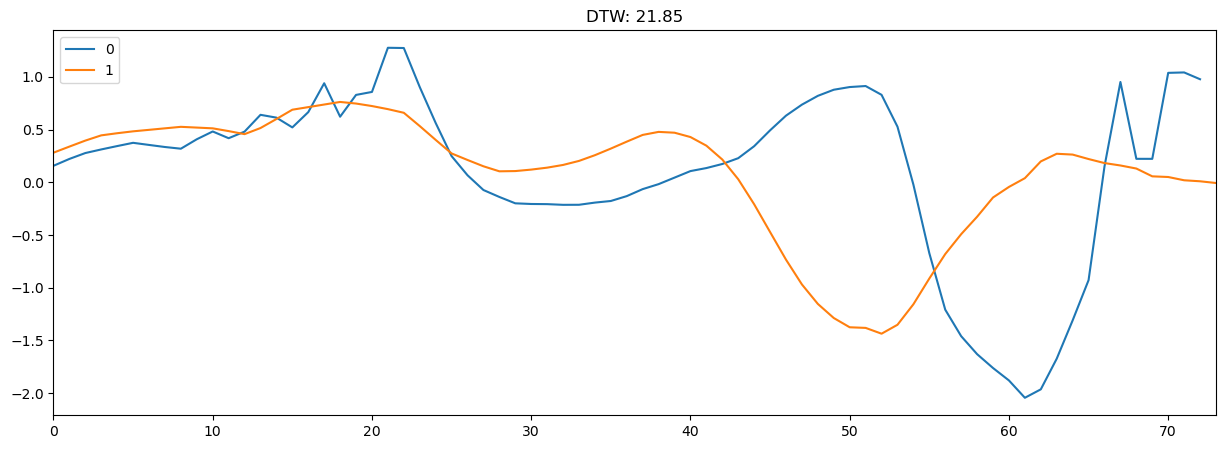

In [12]:
fig, ax = fig_ax()
ax.plot(signal_1, label=label_1)
ax.plot(signal_2, label=label_2)
plt.title(f"DTW: {get_dtw_distance(signal_1,signal_2):.2f}")
_ = plt.legend()

<AxesSubplot:>

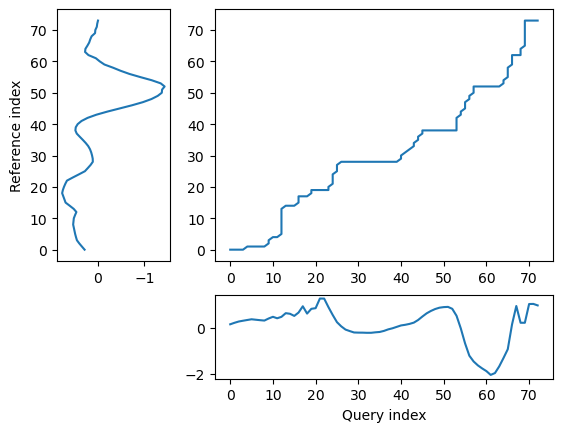

In [39]:
alignment = dtw(signal_1, signal_2, keep_internals=True)
alignment.plot(type="threeway")

In [ ]:
alignment.plot(type="twoway", offset=10)

In [ ]:
signal_0 = X_train[0]
dissimilar_idx = np.argmax([get_dtw_distance(signal_0, signal) for signal in X_train])
dissimilar_signal_0 = X_train[dissimilar_idx]
dissimilar_label_0 = y_train[dissimilar_idx]

similar_idx = np.argmin([get_dtw_distance(signal_0, signal) for signal in X_train[1:]]) + 1
similar_signal_0 = X_train[similar_idx]
similar_label_0 = y_train[similar_idx]

In [ ]:
alignment_sim = dtw(signal_0,similar_signal_0, keep_internals=True)
fig, ax = fig_ax()
ax.plot(signal_0, label=y_train[0])
ax.plot(similar_signal_0, label=similar_label_0)
plt.title(f"DTW: {alignment_sim.distance:.2f}")
_ = plt.legend()

In [ ]:
alignment_sim.plot(type="twoway", offset=10)

#### PREDICTION

In [26]:
def knn_predict(X_train, y_train, X_new, K):
    
    #Calcul la distance de X_new à tous les vecteurs de X_train
    distances = []
    for vec in X_train:
        distances.append(get_dtw_distance(vec,X_new))
    # compléter avec votre code ici
    distances = np.array(distances)
    ordered_index = np.argsort(distances)[:K]
    Y_hat = Counter(np.array(y_train)[ordered_index]).most_common()[0][0]
    
    return Y_hat# la prédiction d'étiquette pour X_new


In [27]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, K=3):
        self.K = K

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X_test):
        return np.array([knn_predict(self.X_train, self.y_train, x_new, self.K) for x_new in X_test])


In [28]:
knn_classifier = KNNClassifier(3)
knn_classifier.fit(X_train,y_train)

KNNClassifier()

In [29]:
K = 5
knn_predict(X_train,y_train,X[0],K)

1

In [30]:
y_pred = knn_classifier.predict(X_test)

In [41]:
param_grid = {'K': [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

# Utiliser le score F1 comme critère de performance
f1_scorer = make_scorer(f1_score)

# Initialiser GridSearchCV avec validation croisée 5-fold
grid_search = GridSearchCV(KNNClassifier(), param_grid, cv=KFold(5), scoring=f1_scorer)

# Exécuter la recherche de grille sur les données
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNNClassifier(),
             param_grid={'K': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]},
             scoring=make_scorer(f1_score))

In [42]:
best_K = grid_search.best_params_['K']
best_score = grid_search.best_score_
print("Best K:", best_K, "\nBest F-score:", best_score)

Best K: 1 
Best F-score: 0.6138095238095238


In [92]:
y_pred = grid_search.predict(X_test)
y_pred.shape

(88,)

In [94]:
print("Validation set f1_score:",f1_score(y_test,y_pred))

Validation set f1_score: 0.5132743362831859


## Question 11

In [91]:
i1 = 10
print("Badly classified non-healthy")
print("Predict: ", grid_search.predict([X_test[i]]).item())
print("True label: ", y_test[i])

Badly classified non-healthy
Predict:  1
True label:  0


In [87]:
i2 = 33
print("Badly classified healthy")
print("Predict: ", grid_search.predict([X_test[i]]).item())
print("True label: ", y_test[i])

Badly classified healthy
Predict:  1
True label:  0


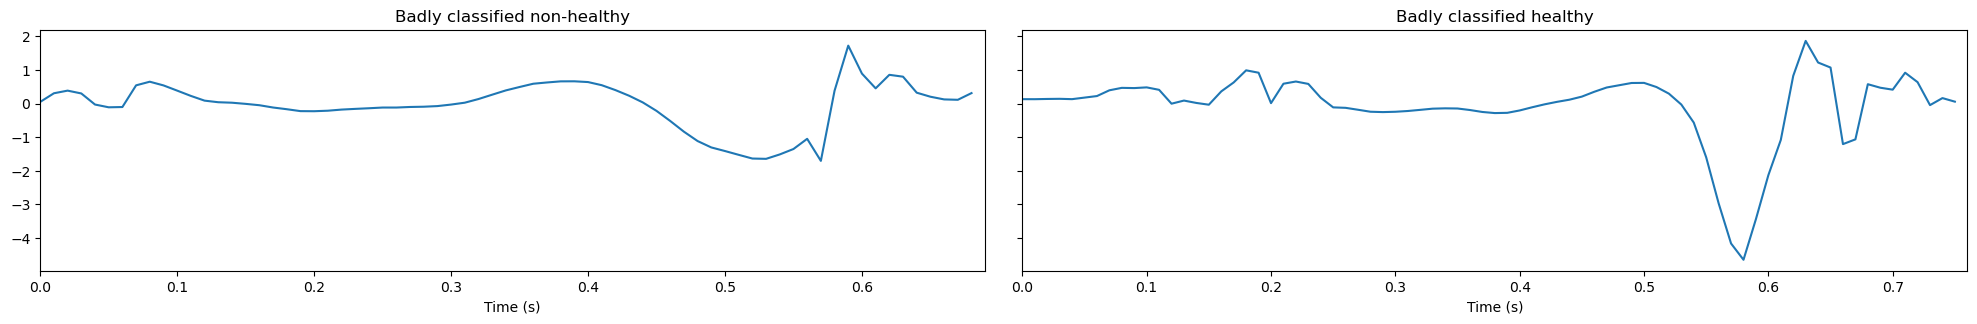

In [89]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([i1, i2], ax_arr):
    s = X_train[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    if ind == i1: case = "non-healthy"
    else: case = "healthy"
    _ = ax.set_title("Badly classified " + case)

Text(0.5, 0, 'Time (s)')

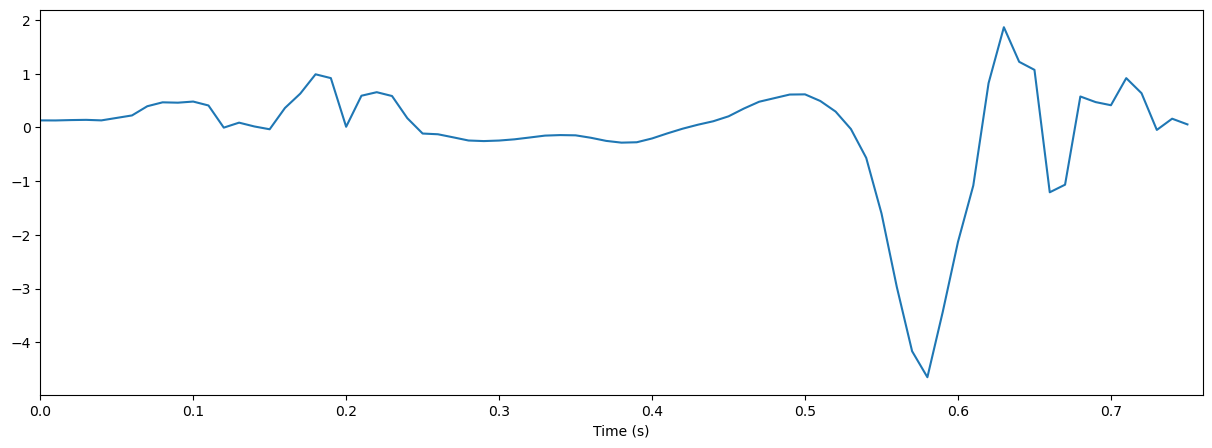

In [98]:
fig, ax = fig_ax()
s = X_train[i2]
tt = np.arange(s.size) / FREQUENCY
ax.plot(tt, s)
ax.set_xlim(0, s.size / FREQUENCY)
ax.set_xlabel("Time (s)")